
1. **Data Loading:**
   Read the Biomass_History.csv and Distance_Matrix.csv files to load the historical biomass availability and travel distance data into Python.


In [159]:
import pandas as pd

# Load Biomass_History.csv
biomass_history = pd.read_csv("../data/Biomass_History.csv")

# Load Distance_Matrix.csv
distance_matrix = pd.read_csv("../data/Distance_Matrix.csv")


2. **Data Preprocessing:**
   Process the data to handle missing values and organize it for further analysis.


In [160]:
import pandas as pd

# List of columns to be combined (2010 to 2017)
columns_to_combine = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']

# Melt the DataFrame to combine the columns into a single column while retaining the year information
biomass_data = pd.melt(biomass_history, id_vars=['Index', 'Longitude', 'Latitude'], value_vars=columns_to_combine, var_name='Year', value_name='Value')

# Display the updated DataFrame
print(biomass_data)



       Index  Longitude  Latitude  Year      Value
0          0   71.33144  24.66818  2010   8.475744
1          1   71.41106  24.66818  2010  24.029778
2          2   71.49069  24.66818  2010  44.831635
3          3   71.57031  24.66818  2010  59.974419
4          4   71.64994  24.66818  2010  14.653370
...      ...        ...       ...   ...        ...
19339   2413   72.84432  20.15456  2017   5.321604
19340   2414   72.92394  20.15456  2017   0.120626
19341   2415   73.00357  20.15456  2017   0.038879
19342   2416   73.08319  20.15456  2017   1.304297
19343   2417   73.16282  20.15456  2017   0.226953

[19344 rows x 5 columns]


3. **Biomass Forecasting: Using Linear Regression**
   Use time-series forecasting methods like ARIMA or Prophet to predict biomass availability for the years 2018 and 2019.


/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


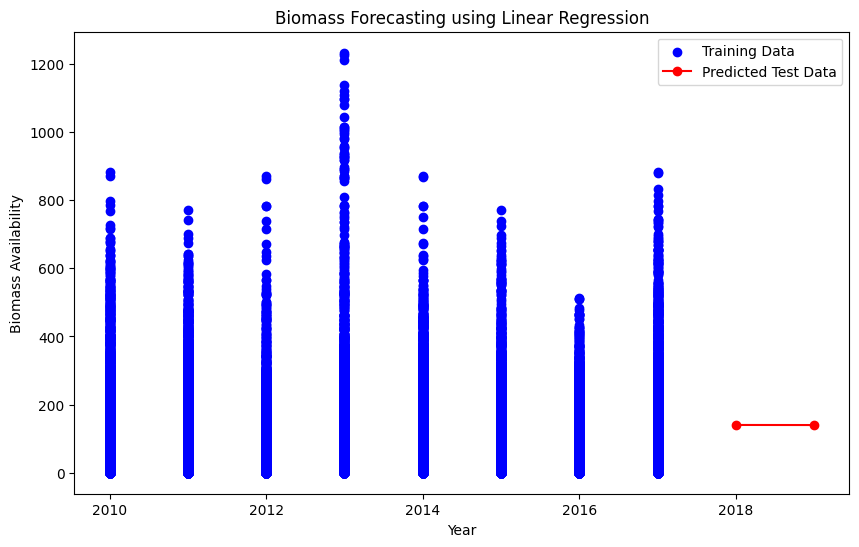

In [161]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Convert the 'Year' column to numeric
biomass_data['Year'] = pd.to_numeric(biomass_data['Year'])

# Split the data into training (2010-2017) and testing (2018-2019) sets
train_data = biomass_data[biomass_data['Year'] <= 2017]
test_data = biomass_data[biomass_data['Year'] >= 2018]

# Create a linear regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(train_data[['Year']], train_data['Value'])

# Predict biomass availability for the years 2018 and 2019

years_to_predict = [2018, 2019]
predictions = model.predict(np.array(years_to_predict).reshape(-1, 1))

# Create a DataFrame to store the predictions
biomass_predictions = pd.DataFrame({'Year': years_to_predict, 'Predicted_Value': predictions})

biomass_predictions = pd.merge(biomass_predictions, biomass_data[['Index', 'Year']], on='Year', how='left')

# Save biomass_predictions to a CSV file
biomass_predictions.to_csv("../data/predicted_biomass.csv", index=False)

# Visualize the predictions
plt.figure(figsize=(10, 6))
plt.scatter(train_data['Year'], train_data['Value'], label='Training Data', color='blue')
plt.plot(years_to_predict, predictions, label='Predicted Test Data', color='red', marker='o')
plt.xlabel('Year')
plt.ylabel('Biomass Availability')
plt.title('Biomass Forecasting using Linear Regression')
plt.legend()
plt.show()




4. **Optimal Asset Locations:**
   Implement an optimization algorithm (e.g., Genetic Algorithm, Simulated Annealing, or Linear Programming) to find the optimal locations for preprocessing depots and biorefineries based on the forecasted biomass data and distance matrix.


In [162]:
import pandas as pd
from pulp import LpMaximize, LpProblem, LpVariable, lpSum


# Filter the data for years 2018 and 2019
biomass_data = biomass_data[biomass_data["Year"].isin([2018, 2019])]

# Load the biomass predictions for years 2018 and 2019 from the previous code
biomass_predictions = pd.read_csv("../data/predicted_biomass.csv")

# Merge biomass predictions with distance_matrix based on 'Index'
biomass_data = pd.merge(biomass_data, biomass_predictions, on='Index', how='left')

# Create a list of source indices
source_indices = biomass_data["Index"].tolist()

# Create a list of biorefinery and depot indices
biorefinery_indices = [0, 1, 2]  # Example: Assuming 3 biorefineries
depot_indices = [3, 4, 5]       # Example: Assuming 3 depots

# Create the LP problem
prob = LpProblem(name="Optimal_Asset_Locations", sense=LpMaximize)

# Create binary variables for each source, depot, and biorefinery
sources = LpVariable.dicts("Source", source_indices, cat="Binary")
depots = LpVariable.dicts("Depot", depot_indices, cat="Binary")
biorefineries = LpVariable.dicts("Biorefinery", biorefinery_indices, cat="Binary")

# Objective function: Maximize the total biomass collected
prob += lpSum([biomass_data.loc[biomass_data["Index"] == i, "Predicted_Value"].values[0] * sources[i] for i in source_indices])

# Constraints: Each source must be assigned to one depot or one biorefinery
for i in source_indices:
    prob += lpSum([sources[i], lpSum([distance_matrix.at[i, j] * depots[j] for j in depot_indices]), lpSum([distance_matrix.at[i, k] * biorefineries[k] for k in biorefinery_indices])]) == 1

# Constraints: Total number of depots and biorefineries should be limited
prob += lpSum(depots) <= 2  # Example: Maximum 2 depots allowed
prob += lpSum(biorefineries) <= 1  # Example: Maximum 1 biorefinery allowed

# Constraints: Ensure that only one asset is assigned per location
for i in depot_indices + biorefinery_indices:
    prob += lpSum([depots[j] for j in depot_indices]) + lpSum([biorefineries[k] for k in biorefinery_indices]) <= 1

# Solve the LP problem
prob.solve()

# Print the status of the optimization
print("Status:", prob.status)

# Extract the optimal assignment
optimal_sources = [i for i in source_indices if sources[i].varValue == 1]
optimal_depots = [j for j in depot_indices if depots[j].varValue == 1]
optimal_biorefineries = [k for k in biorefinery_indices if biorefineries[k].varValue == 1]

print("Optimal Sources:", optimal_sources)
print("Optimal Depots:", optimal_depots)
print("Optimal Biorefineries:", optimal_biorefineries)


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/codespace/.python/current/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/da4d1347a9e04db2be59d21cae5dd3eb-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/da4d1347a9e04db2be59d21cae5dd3eb-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 13 COLUMNS
At line 69 RHS
At line 78 BOUNDS
At line 86 ENDATA
Problem MODEL has 8 rows, 7 columns and 42 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 0 to -1.79769e+308
Probing was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
Gomory was tried 0 times and created

5. **Submission:**
   Prepare the output in the desired format and save it to the sample_submission.csv file.


In [163]:
import pandas as pd
from pulp import LpMaximize, LpProblem, LpVariable, lpSum

# Prepare the output DataFrame
output_data = pd.DataFrame(columns=["year", "data_type", "source_index", "destination_index", "value"])

# Assign sources to depots
for source in optimal_sources:
    nearest_depot = min(optimal_depots, key=lambda depot: distance_matrix.at[source, depot])
    output_data = output_data.append({"year": 2018, "data_type": "depot_location", "source_index": source, "destination_index": nearest_depot, "value": 1}, ignore_index=True)

# Assign sources to biorefineries
for source in optimal_sources:
    nearest_biorefinery = min(optimal_biorefineries, key=lambda biorefinery: distance_matrix.at[source, biorefinery])
    output_data = output_data.append({"year": 2018, "data_type": "refinery_location", "source_index": source, "destination_index": nearest_biorefinery, "value": 1}, ignore_index=True)

# Fill biomass_forecast, biomass_demand_supply, and pellet_demand_supply data types with placeholders
for year in [2018, 2019]:
    for source in source_indices:
        output_data = output_data.append({"year": year, "data_type": "biomass_forecast", "source_index": source, "destination_index": 0, "value": 0}, ignore_index=True)
        output_data = output_data.append({"year": year, "data_type": "biomass_demand_supply", "source_index": source, "destination_index": 0, "value": 0}, ignore_index=True)
        output_data = output_data.append({"year": year, "data_type": "pellet_demand_supply", "source_index": source, "destination_index": 0, "value": 0}, ignore_index=True)

# Save the output to sample_submission.csv
output_data.to_csv("../data/submission.csv", index=False)
